<h1>1. Tiền xử lý dữ liệu và Phân tích khai phá dữ liệu</h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import pickle
print("Setup complete.")

Setup complete.


In [3]:
path = "/content/drive/MyDrive/Môn Python thầy Dũng - nhóm 39/Final Project/BankChurners.csv"

<h2>1.1 Nhập dữ liệu</h2>

In [4]:
df = pd.read_csv(path)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Chúng tôi đánh giá trường 'CLIENTNUM' không chứa nhiều giá trị có ích đối với phân tích. Vì vậy chúng tôi loại bỏ trường này ra khỏi bộ dữ liệu.

In [5]:
df = df.drop('CLIENTNUM', axis=1)

<h2>1.2 Xử lý dữ liệu bị thiếu</h2>

Chúng tôi đã kiểm tra các trường bị thiếu dữ liệu trong dataset và số lượng Missing values của từng trường. Phần lớn dữ liệu không bị thiếu dưới dạng trống mà hiển thị ở dạng 'Unknown', chúng tôi sẽ xử lý các giá trị này giống với giá trị bị missing

In [6]:
# đếm giá trị 'Unknown' trong bộ dữ liệu
unknown_counts = (df == 'Unknown').sum()

# Hiển thị số lượng giá trị 'Unknown' theo từng feature
print(unknown_counts)

Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64


Có 3 trường chứa dữ liệu khuyết thiếu 'Unknown', trong đó:
<br>- Education_Level 1519 giá trị
<br>- Marital_Status 749 giá trị
<br>- Income_Category 1112 giá trị

In [7]:
# Create boolean masks for missing values in each feature
missing_feature1 = df['Education_Level'].isnull()
missing_feature2 = df['Marital_Status'].isnull()
missing_feature3 = df['Income_Category'].isnull()

# Combine the boolean masks using the logical AND operator to find records with missing values in all three features
missing_all_features = df[missing_feature1 & missing_feature2 & missing_feature3]

# Count the number of records with missing values in all three features
count_missing_all_features = len(missing_all_features)

# Display the count
print("Number of records missing values in all three features:", count_missing_all_features)


Number of records missing values in all three features: 0


Có thể thấy trong bộ dữ liệu của chúng tôi, không có record nào bị missing cả 3 trường này cùng một lúc, như vậy ta có thể tiến hành xử lý missing value bằng cách xử lý dựa trên mối liên quan với các trường nhân khẩu học còn lại
<br>Đầu tiên có thể giả thiết được rằng trạng thái hôn nhân và tuổi tác sẽ có mối quan hệ tương đối với nhau

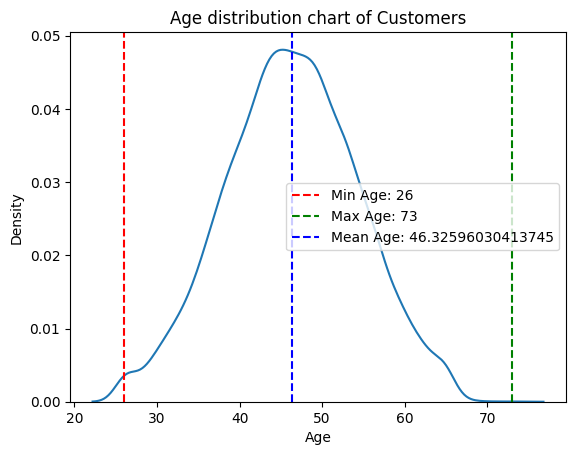

In [8]:
# Xem phân bổ độ tuổi của khách hàng
# Extract min and max age
min_age = df['Customer_Age'].min()
max_age = df['Customer_Age'].max()
mean_age = df['Customer_Age'].mean()

# Plotting the distribution plot
sns.distplot(df['Customer_Age'], bins=30, hist=False)  # Increase the number of bins for more detail
plt.title('Age distribution chart of Customers')
plt.xlabel('Age')

# Adding vertical lines for min and max age
plt.axvline(x=min_age, color='r', linestyle='--', label=f'Min Age: {min_age}')
plt.axvline(x=max_age, color='g', linestyle='--', label=f'Max Age: {max_age}')
plt.axvline(x=mean_age, color='b', linestyle='--', label=f'Mean Age: {mean_age}')
plt.legend()

plt.show()

Độ tuổi nhỏ nhất của KH là 26, lớn nhất là 73 và độ tuổi trung bình là 46.3, tiến hành cắt lớp độ tuổi thành các lớp sau: từ 26 - 35, 36 - 45, 46 - 55, 56 - 73

In [9]:
# create impute_age_group function to group customer's age
def impute_age_group(col):
    birth_incorp_date = col[0]
    if birth_incorp_date < 36:
        return '26_35'
    if birth_incorp_date < 46:
        return '36_45'
    if birth_incorp_date < 56:
        return '46_55'
    else:
        return '56_73'

# Create an 'age_group' feature that contains the customer's age group data
df['Age_group'] = df[['Customer_Age']].apply(impute_age_group, axis = 1)

In [10]:
data = df.sort_index(axis=1)

Chúng ta sẽ xem xu hướng tình trạng hôn nhân theo độ tuổi

In [11]:
# Create a dummy variable to calculate the number of occurrences of the values in the 'vn_marital_status'.
data['test_column'] = 1

# Create a data_grtest consisting of observations of 3 features: 'vn_marital_status', 'age_group', 'test_column'
data_grtest = data[['Marital_Status', 'Age_group', 'test_column']]

# Create a dataframe showing frequency of the values in the 'vn_marital_status' appear by age group
group_test = data_grtest.groupby(['Age_group', 'Marital_Status'], as_index = False).sum()

# Create a function to find the value with the highest occurrence of each age group
def marital_status(age_group):
    sub_group = group_test[group_test['Age_group'] == age_group]
    sub_group= sub_group[sub_group['test_column'] == sub_group['test_column'].max()]
    return sub_group.iloc[0]['Marital_Status']

# Create a dictionary showing common marital status corresponding to each customer age group
Age_group = group_test['Age_group'].unique().tolist()
my_dict = {age_group:marital_status(age_group) for age_group in Age_group}
my_dict

{'26_35': 'Single', '36_45': 'Married', '46_55': 'Married', '56_73': 'Married'}

Sau khi đã tìm ra được xu hướng trạng thái hôn nhân theo độ tuổi, chúng tôi tiến hành thay thế giá trị 'Unknown' của trường trạng thái hôn nhân theo độ tuổi

In [12]:
def impute_marrital_status(cols):
    Marital_Status = cols[0]
    Age_group = cols[1]
    if Marital_Status == 'Unknown':
        if (Age_group == '26_35'):
            return 'Single'
        else:
            return 'Married'
    else:
        return Marital_Status

In [13]:
data['Marital_Status'] = data[['Marital_Status', 'Age_group']].apply(impute_marrital_status, axis = 1)

Tiếp tục tiến hành thay thế giá trị "Unknown" tại trường thu nhập, ta sẽ xem xu hướng thu nhập của khách hàng dựa trên trường độ tuổi, giới tính và học vấn

In [14]:
# Create data_grtest1 consisting observations of 4 features: 'Age_group', 'Gender', 'Income_Category', 'test_column'
data_grtest1 = data[['Age_group', 'Gender', 'Income_Category', 'Education_Level', 'test_column']]

# Group the data by 'Age_group', 'Gender', 'Income_Category' and calculate the sum
group_test1 = data_grtest1.groupby(['Age_group', 'Gender', 'Education_Level', 'Income_Category'], as_index=False).sum()

# Define a function to impute the most frequent education level for each age group, gender, and income category
def impute(cols):
    age_group = cols[0]
    gender = cols[1]
    education_level = cols[2]
    sub_group = group_test1[(group_test1['Age_group'] == age_group) &
                            (group_test1['Gender'] == gender) &
                            (group_test1['Education_Level'] == education_level)]
    sub_group = sub_group[sub_group['test_column'] == sub_group['test_column'].max()]
    return sub_group.iloc[0]['Income_Category']

# Create a DataFrame with 'Age_group' and 'Gender' for applying the impute function
sub_group2 = group_test1[['Age_group', 'Gender', 'Education_Level']]

# Apply the impute function to add the 'Education_Level' feature
sub_group2['Income_Category'] = sub_group2.apply(impute, axis=1)
sub_group2 = sub_group2.drop_duplicates()
# Display the DataFrame with the added 'Education_Level' feature
sub_group2.head(30)


,Age_group,Gender,Education_Level,Income_Category
0,26_35,F,College,Less than $40K
3,26_35,F,Doctorate,Less than $40K
6,26_35,F,Graduate,Less than $40K
9,26_35,F,High School,Less than $40K
12,26_35,F,Post-Graduate,Less than $40K
15,26_35,F,Uneducated,Less than $40K
18,26_35,F,Unknown,Less than $40K
21,26_35,M,College,$80K - $120K
27,26_35,M,Doctorate,$40K - $60K
31,26_35,M,Graduate,$40K - $60K


In [15]:
# Merge and update
merged_df = pd.merge(left=data, right=sub_group2, how='left', on=['Age_group', 'Gender', 'Education_Level'])
data.loc[data['Income_Category'] == 'Unknown', 'Income_Category'] = merged_df[merged_df['Income_Category_x'] == 'Unknown']['Income_Category_y'].fillna(data['Income_Category'])

In [16]:
# đếm giá trị 'Unknown' trong bộ dữ liệu
unknown_counts = (data == 'Unknown').sum()

# Hiển thị số lượng giá trị 'Unknown' theo từng feature
print(unknown_counts)

Age_group                      0
Attrition_Flag                 0
Avg_Open_To_Buy                0
Avg_Utilization_Ratio          0
Card_Category                  0
Contacts_Count_12_mon          0
Credit_Limit                   0
Customer_Age                   0
Dependent_count                0
Education_Level             1519
Gender                         0
Income_Category                0
Marital_Status                 0
Months_Inactive_12_mon         0
Months_on_book                 0
Total_Amt_Chng_Q4_Q1           0
Total_Ct_Chng_Q4_Q1            0
Total_Relationship_Count       0
Total_Revolving_Bal            0
Total_Trans_Amt                0
Total_Trans_Ct                 0
test_column                    0
dtype: int64


Chỉ còn trường Education_Level còn 1519 giá trị 'Unknown', tiếp tục xem xu hướng trình độ học vấn dựa trên tuổi, thu nhập và hôn nhân

In [17]:
# Create data_grtest1 consisting observations of 4 features: 'Age_group', 'Gender', 'Income_Category', 'test_column'
data_grtest1 = data[['Age_group', 'Income_Category', 'Marital_Status', 'Education_Level', 'test_column']]

# Group the data by 'Age_group', 'Gender', 'Income_Category' and calculate the sum
group_test1 = data_grtest1.groupby(['Age_group', 'Income_Category', 'Marital_Status', 'Education_Level'], as_index=False).sum()

# Define a function to impute the most frequent education level for each age group, gender, and income category
def impute(cols):
    age_group = cols[0]
    income_category = cols[1]
    marital_status = cols[2]
    sub_group = group_test1[(group_test1['Age_group'] == age_group) &
                            (group_test1['Income_Category'] == income_category) &
                            (group_test1['Marital_Status'] == marital_status)]
    sub_group = sub_group[sub_group['test_column'] == sub_group['test_column'].max()]
    return sub_group.iloc[0]['Education_Level']

# Create a DataFrame with 'Age_group' and 'Gender' for applying the impute function
sub_group2 = group_test1[['Age_group', 'Income_Category', 'Marital_Status']]

# Apply the impute function to add the 'Education_Level' feature
sub_group2['Education_Level'] = sub_group2.apply(impute, axis=1)
sub_group2 = sub_group2.drop_duplicates()
# Display the DataFrame with the added 'Education_Level' feature
sub_group2.head(50)

,Age_group,Income_Category,Marital_Status,Education_Level
0,26_35,$120K +,Divorced,Uneducated
2,26_35,$120K +,Married,Graduate
8,26_35,$120K +,Single,Graduate
13,26_35,$40K - $60K,Divorced,Graduate
18,26_35,$40K - $60K,Married,Graduate
25,26_35,$40K - $60K,Single,Graduate
32,26_35,$60K - $80K,Divorced,Graduate
36,26_35,$60K - $80K,Married,High School
43,26_35,$60K - $80K,Single,Uneducated
50,26_35,$80K - $120K,Divorced,Graduate


In [18]:
# Merge and update
merged_df = pd.merge(left=data, right=sub_group2, how='left', on=['Age_group', 'Income_Category', 'Marital_Status'])
data.loc[data['Education_Level'] == 'Unknown', 'Education_Level'] = merged_df[merged_df['Education_Level_x'] == 'Unknown']['Education_Level_y'].fillna(data['Education_Level'])

Loại bỏ 6 dòng có giá trị Education_level = "Unknown"

In [19]:
data = data[data['Education_Level'] != "Unknown"]
data.shape

(10121, 22)

In [20]:
# đếm giá trị 'Unknown' trong bộ dữ liệu
unknown_counts = (data == 'Unknown').sum()

# Hiển thị số lượng giá trị 'Unknown' theo từng feature
print(unknown_counts)

Age_group                   0
Attrition_Flag              0
Avg_Open_To_Buy             0
Avg_Utilization_Ratio       0
Card_Category               0
Contacts_Count_12_mon       0
Credit_Limit                0
Customer_Age                0
Dependent_count             0
Education_Level             0
Gender                      0
Income_Category             0
Marital_Status              0
Months_Inactive_12_mon      0
Months_on_book              0
Total_Amt_Chng_Q4_Q1        0
Total_Ct_Chng_Q4_Q1         0
Total_Relationship_Count    0
Total_Revolving_Bal         0
Total_Trans_Amt             0
Total_Trans_Ct              0
test_column                 0
dtype: int64


Chúng tôi đã xử lý xong các giá trị missing

<h2>1.3 Trực quan hóa dữ liệu</h2>

Chúng tôi đã visualize các trường trong bộ dữ liệu để đánh giá sơ bộ về sự phân bố giữa Churn Customer và Active Customer. Từ đó, chúng tôi đã rút ra một số insights về những biểu hiện của Churn Customer.
<br>
Đối với từng kiểu data, chúng tôi sẽ visualize bằng các biểu đồ khác nhau. Do đó, chúng tôi đã sắp xếp các trường trong bộ dữ liệu vào 2 danh sách như sau:
<br>- List 1 - 'numerical_columns': Danh sách này chứa các trường có chứa kiểu dữ liệu dạng số (numerical)
<br>- List 2 - 'categorical_columns': Danh sách này chứa các trường có chứa kiểu dữ liệu dạng phân loại (categorical)

In [ ]:
data = data.drop('test_column', axis=1)

In [ ]:
#  Tạo 2 danh sách gồm: numerical_columns và categorical_columns
numerical_columns = []
categorical_columns = []
for column in data.columns:
    if data[column].dtype == 'O':
        if column != 'Attrition_Flag':
            categorical_columns.append(column)
    else:
        numerical_columns.append(column)

Chúng tôi đã chia bộ dữ liệu thành 2 lớp:
<br>- data_churn: đây là bộ dữ liệu chứa các quan sát là churn customer
<br>-
data_active: đây là bộ dữ liệu chứa các quan sát là active customer

In [ ]:
data['Attrition_Flag'].value_counts()

Attrition_Flag
Existing Customer    8497
Attrited Customer    1624
Name: count, dtype: int64

In [ ]:
data_churn = data[data['Attrition_Flag'] == 'Attrited Customer']
data_active = data[data['Attrition_Flag'] == 'Existing Customer']

Chúng tôi trực quan hóa tất cả các trường trong danh sách numerical_columns bằng biểu đồ KDE plots.

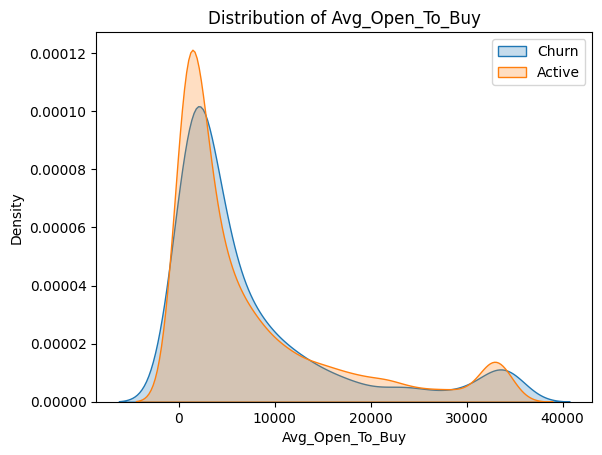

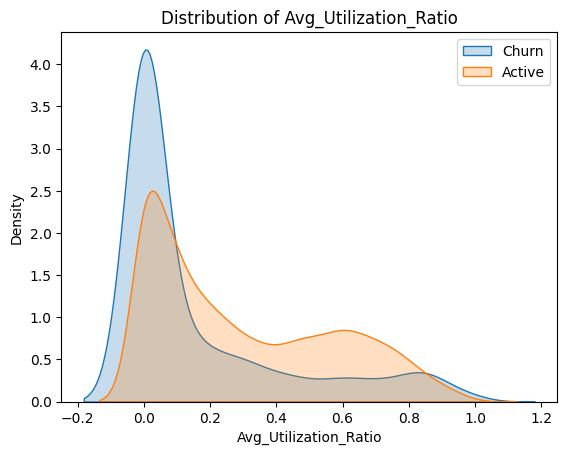

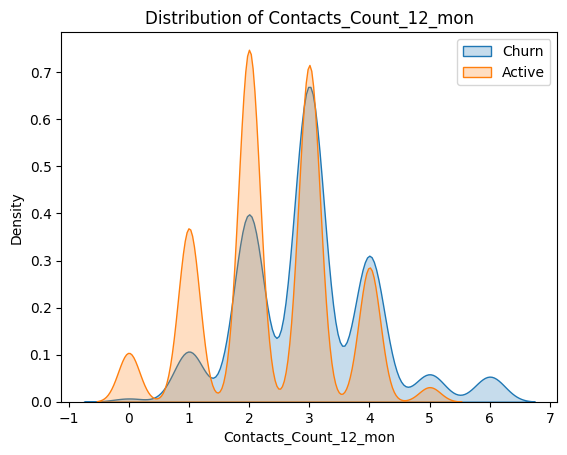

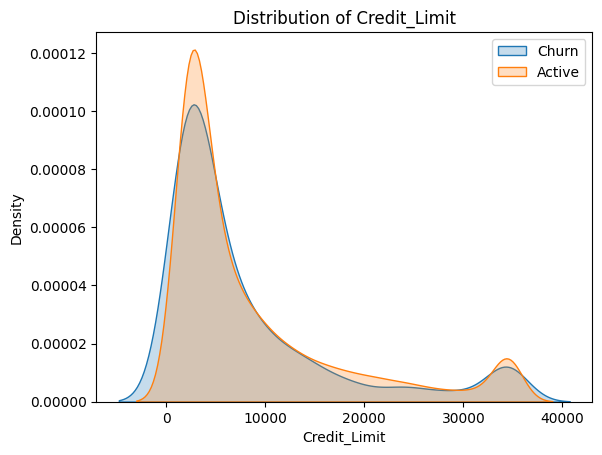

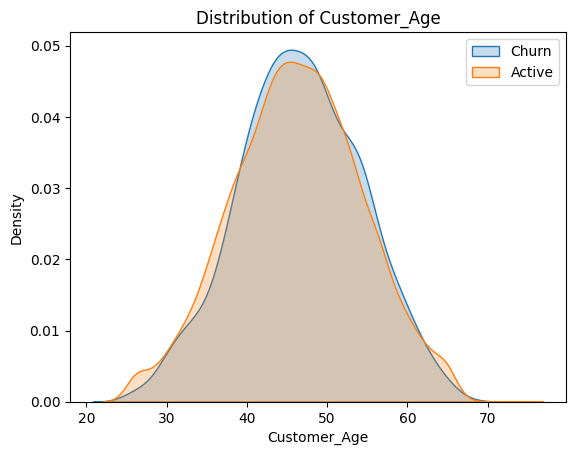

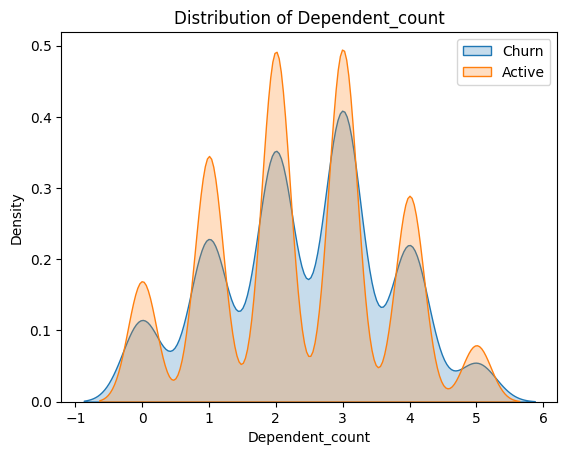

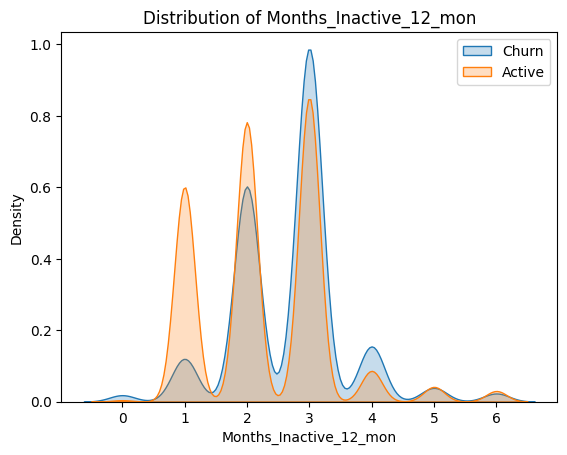

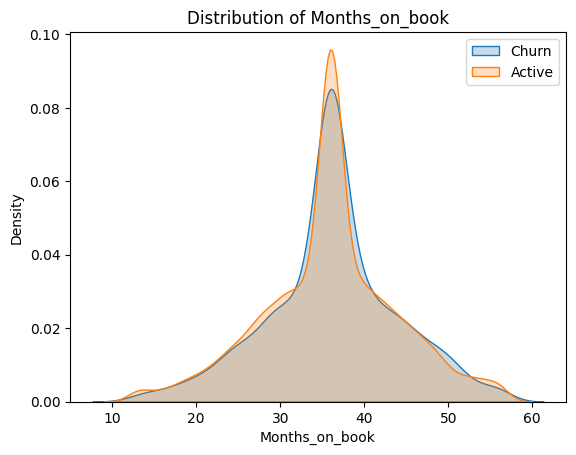

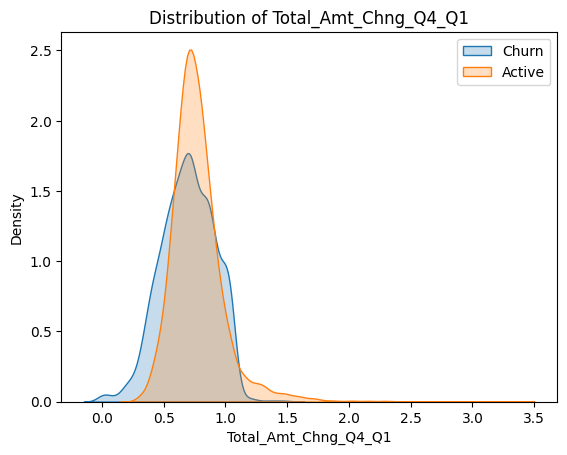

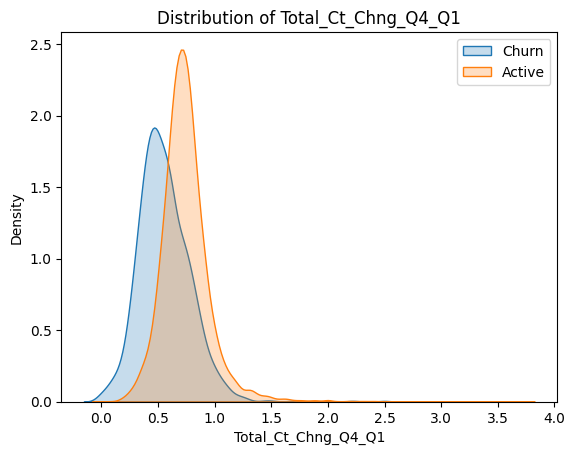

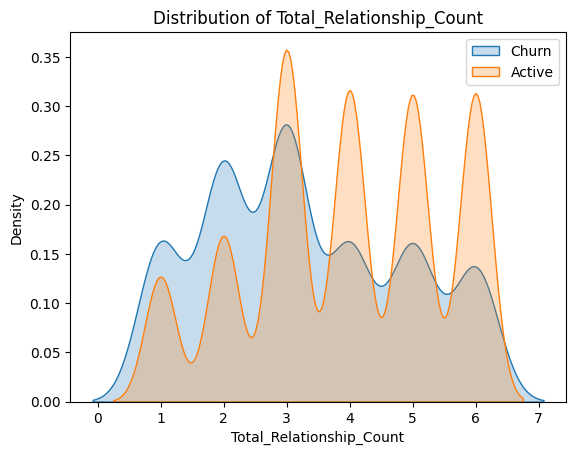

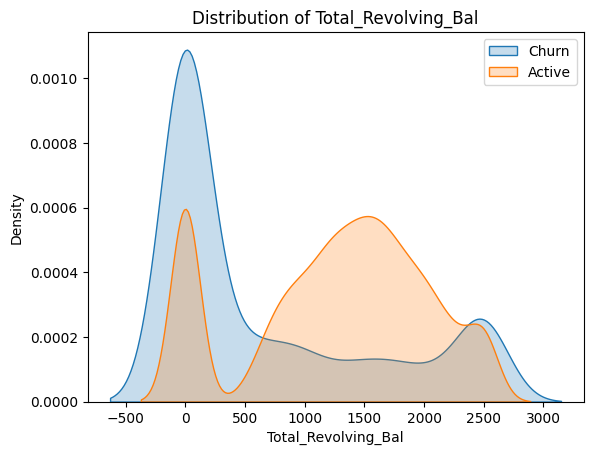

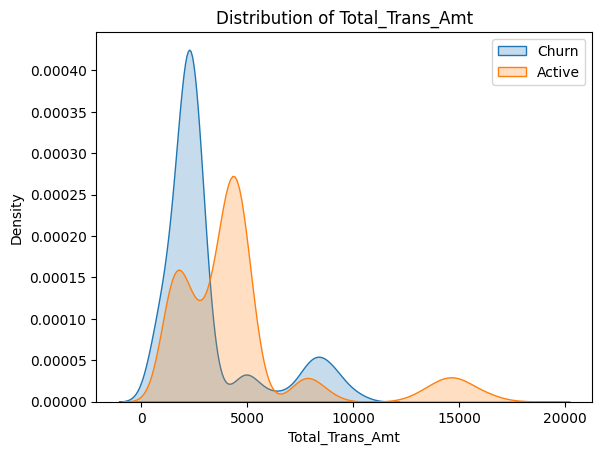

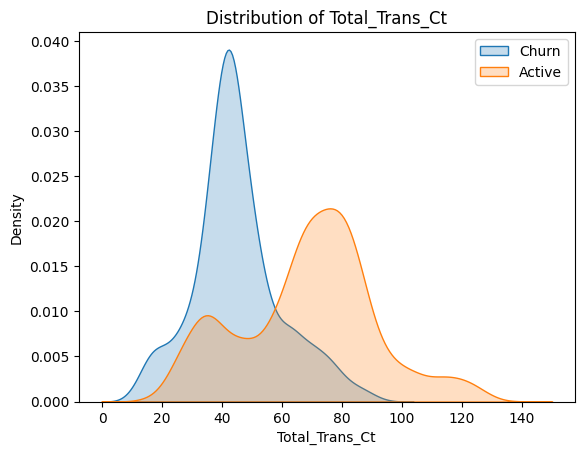

In [ ]:
def KDEPlots(df1,df2,label1,label2,column):
    plt.figure()
    sns.kdeplot(data=df1,label=label1, shade=True)
    sns.kdeplot(data=df2,label=label2,shade=True)
    plt.legend()
    plt.title("Distribution of " +column)
    return

for column in numerical_columns:
    KDEPlots(data_churn[column],data_active[column],'Churn','Active',column)

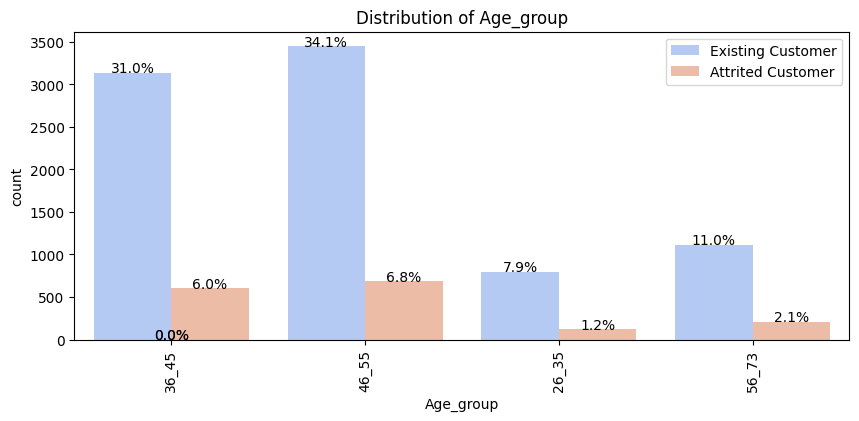

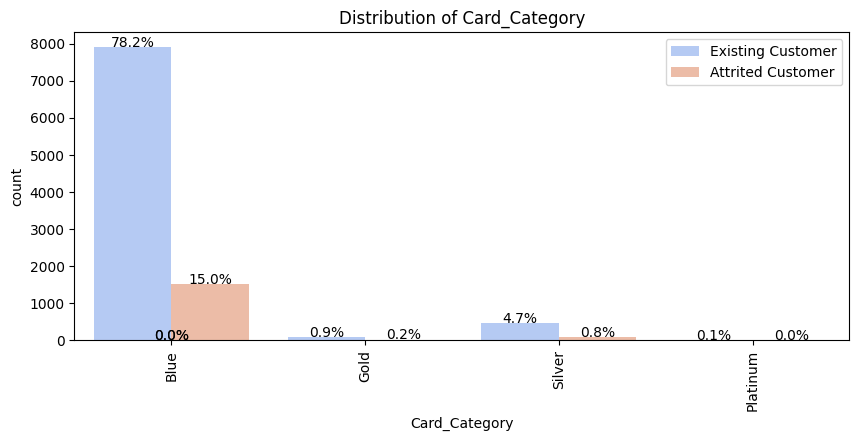

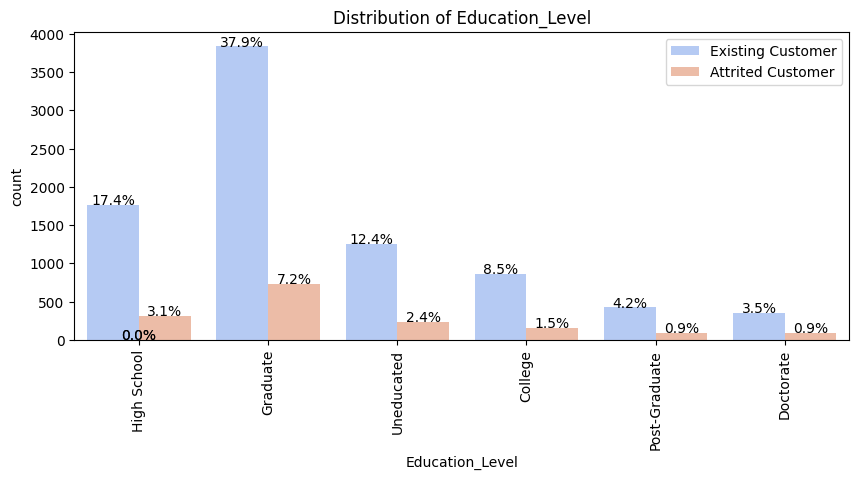

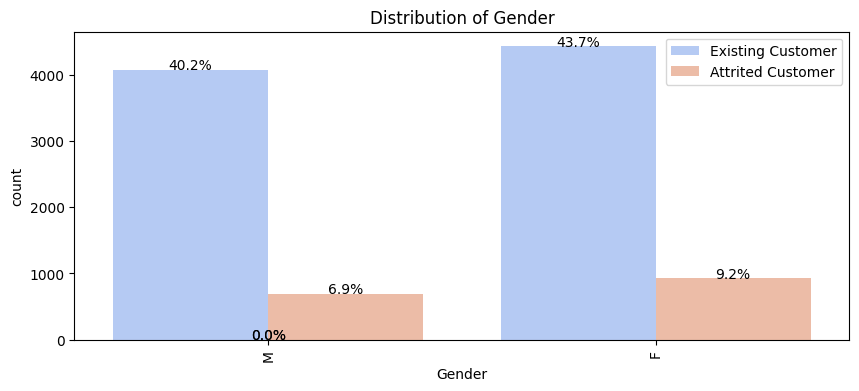

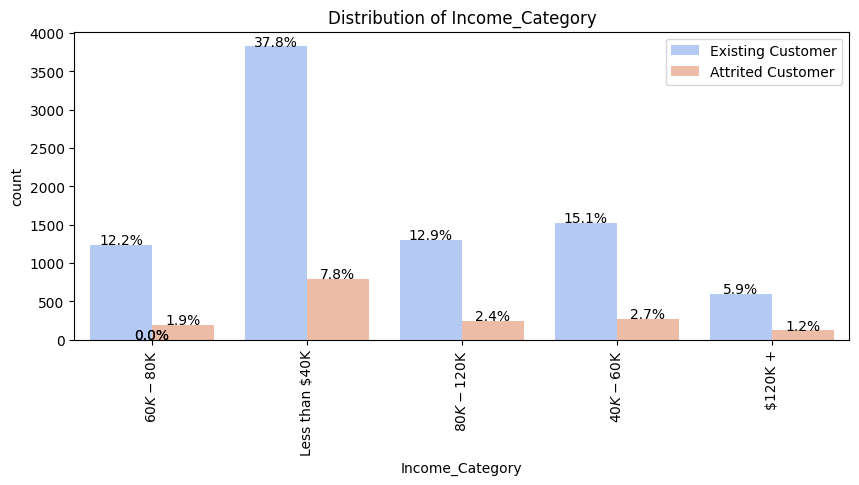

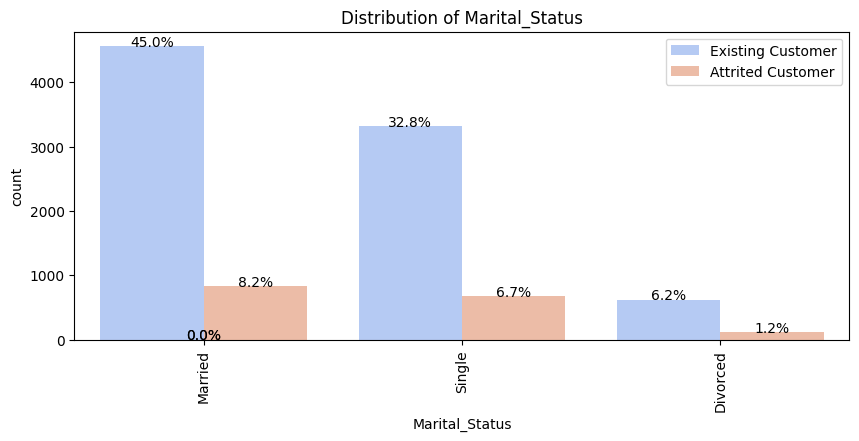

In [ ]:
def DistPlot(df, hue, column):
    plt.figure(figsize=(10, 4))
    plt.xticks(rotation=90)
    sns.countplot(x=column, hue=hue, palette="coolwarm", data=df)
    plt.title("Distribution of " + column)
    plt.legend()

    # Calculate and display percentages
    total_count = df[column].count()
    ax = plt.gca()
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:.1f}%'.format((height / total_count) * 100),
                ha="center")

    return

# Assuming categorical_columns is defined
for column in categorical_columns:
    DistPlot(data, 'Attrition_Flag', column)

Một số đặc điểm của khách hàng có xu hướng rời bỏ dịch vụ thẻ tín dụng:
<br>- Khách hàng đã không còn sử dụng tín dụng thường xuyên nữa (Avg Utilization Ratio = 0)
<br>- Thường xuyên khiếu nại lên khách hàng, số lần khiếu nại với ngân hàng trong vòng 12 tháng gần nhất là 3 hoặc 4 lần, so với chủ yêu <= 3 của khách hàng active
<br>- Tỉ lệ số giao dịch trong Q4 giảm mạnh so với Q1, chỉ đạt < 0.5 so với Q1, khách hàng active có tỉ trọng > 0.5
<br>- Chỉ sở hữu <= 3 thẻ, trong khi đó khách hàng active có số lượng thẻ thường > 3
<br>- Tổng số dư quay vòng trên thẻ chủ yếu = 0
<br>- Tổng số lần giao dịch thấp, bình quân chỉ ~40/năm (KH active ~70/năm), giá trị giao dịch thấp, phần lớn không phát sinh trong năm
<br>- Độ tuổi từ 36 đến 55
<br>- Tỉ lệ khách hàng là nữ cao hơn
<br>- Thu nhập thấp hơn 40k$/năm
<br>- Trạng thái hôn nhân thường là đã kết hôn hoặc độc thân

<h1>2. Xây dựng mô hình

<h2>2.1 Encoding dữ liệu kiểu categorical

In [21]:
category_col =['Marital_Status', 'Income_Category', 'Gender', 'Education_Level', 'Card_Category', 'Attrition_Flag']
lbl_data = data.copy()
df_input = data[category_col].copy()
enc = preprocessing.LabelEncoder()
encoder_dict = dict()
for cat in category_col:
    df_input[cat] = df_input[cat].str.lstrip()
    enc = enc.fit(list(df_input[cat]))
    encoder_dict[cat] = [cat for cat in enc.classes_]
    lbl_data[cat] = enc.transform(df_input[cat])

In [22]:
print(encoder_dict)

{'Marital_Status': ['Divorced', 'Married', 'Single'], 'Income_Category': ['$120K +', '$40K - $60K', '$60K - $80K', '$80K - $120K', 'Less than $40K'], 'Gender': ['F', 'M'], 'Education_Level': ['College', 'Doctorate', 'Graduate', 'High School', 'Post-Graduate', 'Uneducated'], 'Card_Category': ['Blue', 'Gold', 'Platinum', 'Silver'], 'Attrition_Flag': ['Attrited Customer', 'Existing Customer']}


In [23]:
encoder_pickle_out = open("encoder.pkl", "wb")
pickle.dump(encoder_dict, encoder_pickle_out)
encoder_pickle_out.close()

In [24]:
lbl_data = lbl_data.drop('Age_group', axis=1)

In [ ]:
X = lbl_data.drop('Attrition_Flag', axis = 1)
Y = lbl_data['Attrition_Flag']

<h2>2.2 Chia tập dữ liệu thành 2 tập train và test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 100)

<h2>2.3 Train & Test Data using Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("Recall Score:", recall_score(y_test, ypred))
print("Precision Score:", precision_score(y_test, ypred))
print("ROC AUC Score: ", roc_auc_score(y_test, ypred))
rf_fp, rf_tp, rf_threshold = roc_curve(y_test, ypred)
print("Threshold:", rf_threshold)

[[ 386   79]
 [  40 2532]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       465
           1       0.97      0.98      0.98      2572

    accuracy                           0.96      3037
   macro avg       0.94      0.91      0.92      3037
weighted avg       0.96      0.96      0.96      3037

Accuracy Score: 0.9608165953243333
Recall Score: 0.9844479004665629
Precision Score: 0.9697433933358867
ROC AUC Score:  0.9072777136741417
Threshold: [2 1 0]


<h2>2.4 Train & Test Data using Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, random_state=0)
gbc.fit(X_train, y_train)
ypred = gbc.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("Recall Score:", recall_score(y_test, ypred))
print("Precision Score:", precision_score(y_test, ypred))
print("ROC AUC Score: ", roc_auc_score(y_test, ypred))
gbc_fp, gbc_tp, gbc_threshold = roc_curve(y_test, ypred)
print("Threshold:", gbc_threshold)

[[ 386   79]
 [  27 2545]]
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       465
           1       0.97      0.99      0.98      2572

    accuracy                           0.97      3037
   macro avg       0.95      0.91      0.93      3037
weighted avg       0.96      0.97      0.96      3037

Accuracy Score: 0.9650971353309187
Recall Score: 0.98950233281493
Precision Score: 0.9698932926829268
ROC AUC Score:  0.9098049298483252
Threshold: [2 1 0]


<h2>2.5 Train & Test Data using Ada Boost Classifier

In [ ]:
abc = AdaBoostClassifier(n_estimators=100, random_state=0)
abc.fit(X_train, y_train)
ypred = abc.predict(X_test)
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
print("Accuracy Score:", accuracy_score(y_test, ypred))
print("Recall Score:", recall_score(y_test, ypred))
print("Precision Score:", precision_score(y_test, ypred))
print("ROC AUC Score: ", roc_auc_score(y_test, ypred))
abc_fp, abc_tp, abc_threshold = roc_curve(y_test, ypred)
print("Threshold:", abc_threshold)

[[ 409   56]
 [  52 2520]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       465
           1       0.98      0.98      0.98      2572

    accuracy                           0.96      3037
   macro avg       0.93      0.93      0.93      3037
weighted avg       0.96      0.96      0.96      3037

Accuracy Score: 0.9644385907145209
Recall Score: 0.9797822706065319
Precision Score: 0.9782608695652174
ROC AUC Score:  0.9296760815398252
Threshold: [2 1 0]


<h2>2.6 ROC Curve

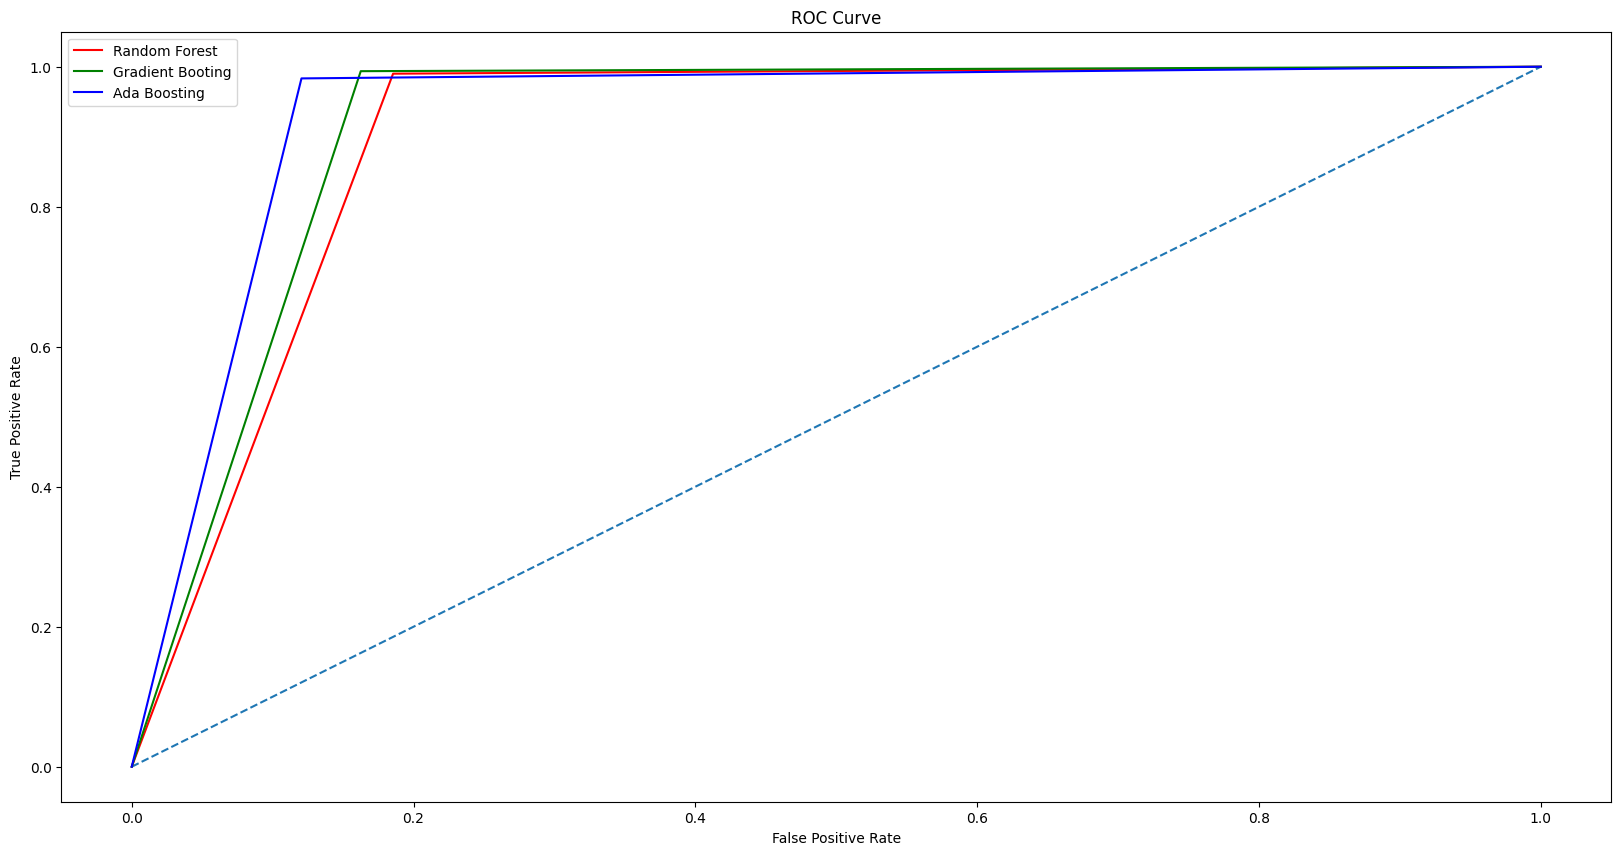

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([0, 1], [0, 1], linestyle = "--")
plt.plot(rf_fp, rf_tp, color="red", label = "Random Forest")
plt.plot(gbc_fp, gbc_tp, color="green", label = "Gradient Booting")
plt.plot(abc_fp, abc_tp, color="blue", label = "Ada Boosting")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

Có thể thấy mặc dù hiệu suất của model Ada Boosting thấp nhất trong 3 model nhưng không quá đáng kể, độ chuẩn xác cũng thấp hơn (88% so với 91% của 2 model còn lại) nhưng độ phủ tương đối cao (88% so với 83) nên ta sẽ lựa chọn model này với hy vọng sẽ cứu được càng nhiều khách hàng rời bỏ càng tốt

<h2>2.7 Get most important features and their contribution in model

In [ ]:
feature_importance_df = pd.DataFrame(X_train.columns, columns=["Feature"])
feature_importance_df["Importance"] = abc.feature_importances_
feature_importance_df.sort_values('Importance', ascending=False, inplace=True)
feature_importance_df = feature_importance_df.head(20)
feature_importance_df

,Feature,Importance
17,Total_Trans_Amt,0.33
18,Total_Trans_Ct,0.16
13,Total_Amt_Chng_Q4_Q1,0.10
5,Customer_Age,0.07
3,Contacts_Count_12_mon,0.05
16,Total_Revolving_Bal,0.05
14,Total_Ct_Chng_Q4_Q1,0.05
10,Marital_Status,0.03
15,Total_Relationship_Count,0.03
11,Months_Inactive_12_mon,0.03


Text(0.5, 1.0, 'Plot Feature Importances')

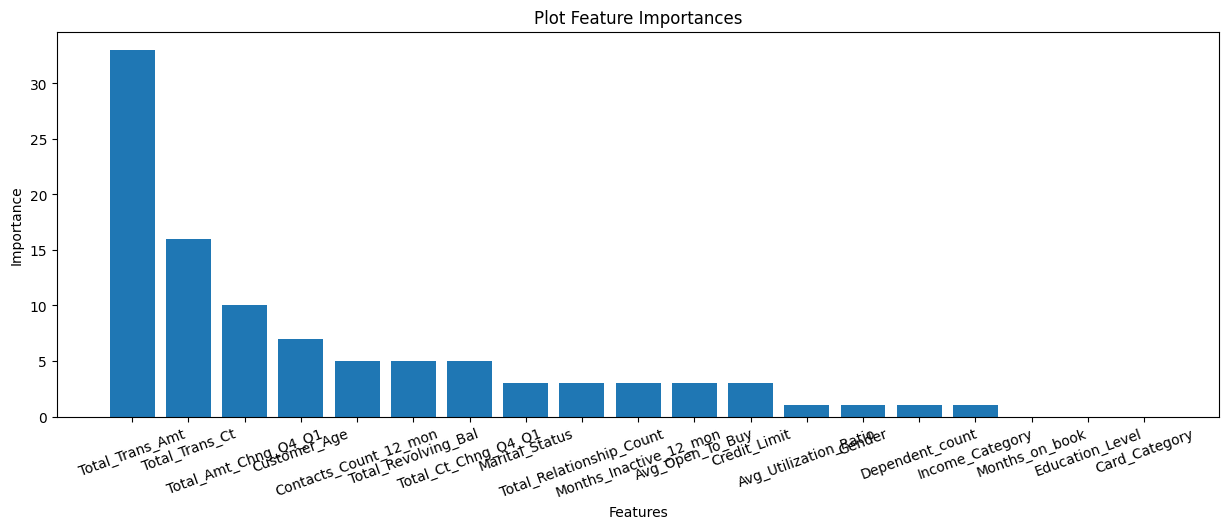

In [ ]:
plt.figure(figsize=(15,5))
ax = feature_importance_df['Feature']
plt.bar(range(feature_importance_df.shape[0]), feature_importance_df['Importance']*100)
plt.xticks(range(feature_importance_df.shape[0]), feature_importance_df['Feature'], rotation = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Plot Feature Importances")

In [ ]:
pickle_out = open("model.pkl", "wb")
pickle.dump(abc, pickle_out)
pickle_out.close()

In [ ]:
pkl_file = open('encoder.pkl', 'rb')
encoder_dict = pickle.load(pkl_file)
pkl_file.close()